In [169]:
import json, csv, colorsys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
import sklearn.metrics as metrics
import sklearn.manifold as manifold
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
from sklearn.utils.extmath import randomized_svd
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
word_re = re.compile(r"[\w']+")
# np.set_printoptions(threshold=np.nan)

In [303]:
def word_cloud(text):
    stopwords = set(STOPWORDS)
    newstoplist = ["twitter",'pic','leave','leaving','remain', 'vote','Brexit', 'via', 'will','BBC','html','unlock','flag']
    for i in newstoplist: stopwords.add(i)
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white", max_words=2000, stopwords=stopwords).generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud)
    plt.axis("off")

    
    # lower max_font_size
    wordcloud = WordCloud(background_color="white", max_font_size=40, max_words=2000, stopwords=stopwords).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
# set the colors we use to plot
def set_color(num):
    ah = 1.0 / num
    l = 0.6
    s = 0.8
    
    colors = [list(colorsys.hls_to_rgb(i * ah, l ,s)) for i in range(num)]
    colors = np.array(colors)
    return colors

In [174]:
# The function we use to draw figure
def draw_scatter(X,title, label = [], num = 0):
    fig = plt.figure(1)
    plt.title(title)
    if len(label) == 0:
        plt.scatter(X[:,0], X[:,1], alpha=0.5)
    else:
        inde = defaultdict(list)
        for i, e in enumerate(label):
            inde[e].append(i)
        colors = set_color(num)
        ax = plt.subplot(111)
        for i in range(num):
            plt.scatter(X[inde[i],0], X[inde[i],1], color=colors[i], alpha=0.5)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        plt.legend(range(num), scatterpoints=1, prop={'size':6},loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.xticks(())
    plt.yticks(())

In [27]:
def draw_plot(x, xlabel, ylabel):
    _=plt.figure(1)
    dummy = plt.figure(figsize=(15,5))
    dummy = plt.plot(range(0,len(x)),x, '-o')
    plt.xticks(range(len(x)))
    plt.grid()
    plt.ylabel(ylabel,size=15)
    plt.xlabel(xlabel,size=15)

In [6]:
df_remain = pd.read_csv('remain.csv')
df_leave = pd.read_csv('leave.csv')

/home/grad3/zhidou/miniconda3/envs/cs505/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
texts = []
for text in df_remain['text']:
    words = []
    for word in word_re.findall(text):
        if word.isdigit(): continue
        words.append(word)
    texts.append(' '.join(words))
df_remain['text'] = texts 
del texts
texts = []
for text in df_leave['text']:
    words = []
    for word in word_re.findall(text):
        if word.isdigit(): continue
        words.append(word)
    texts.append(' '.join(words))
df_leave['text'] = texts 
del texts

In [8]:
stemmer = PorterStemmer()
stemmed_data = [" ".join(stemmer.stem(word)  for sent in sent_tokenize(message) for word in word_tokenize(sent)) for message in df_remain['text']]
df_remain['text2'] = stemmed_data
del stemmed_data
stemmed_data = [" ".join(stemmer.stem(word)  for sent in sent_tokenize(message) for word in word_tokenize(sent)) for message in df_leave['text']]
df_leave['text2'] = stemmed_data
del stemmed_data

In [9]:
Vectorize1 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_remain = Vectorize1.fit_transform(df_remain['text'].values)
Vectorize2 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_remain_stem = Vectorize2.fit_transform(df_remain['text2'].values)
Vectorize3 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_leave = Vectorize3.fit_transform(df_leave['text'].values)
Vectorize4 = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm_leave_stem = Vectorize4.fit_transform(df_leave['text2'].values)

In [10]:
dtm_dense_remain = dtm_remain.todense()
centered_dtm_remain = dtm_dense_remain - np.mean(dtm_dense_remain, axis = 0)
del dtm_dense_remain, dtm_remain
dtm_dense_remain_stem = dtm_remain_stem.todense()
centered_dtm_remain_stem = dtm_dense_remain_stem - np.mean(dtm_dense_remain_stem, axis = 0)
del dtm_dense_remain_stem, dtm_remain_stem
dtm_dense_leave = dtm_leave.todense()
centered_dtm_leave = dtm_dense_leave - np.mean(dtm_dense_leave, axis = 0)
del dtm_dense_leave, dtm_leave
dtm_dense_leave_stem = dtm_leave_stem.todense()
centered_dtm_leave_stem = dtm_dense_leave_stem - np.mean(dtm_dense_leave_stem, axis = 0)
del dtm_dense_leave_stem, dtm_leave_stem

In [11]:
U1, S1, VT1 = randomized_svd(centered_dtm_remain, n_components=40, n_iter=10)
del centered_dtm_remain
U2, S2, VT2 = randomized_svd(centered_dtm_remain_stem, n_components=40, n_iter=10)
del centered_dtm_remain_stem
U3, S3, VT3 = randomized_svd(centered_dtm_leave, n_components=40, n_iter=10)
del centered_dtm_leave
U4, S4, VT4 = randomized_svd(centered_dtm_leave_stem, n_components=40, n_iter=10)
del centered_dtm_leave_stem

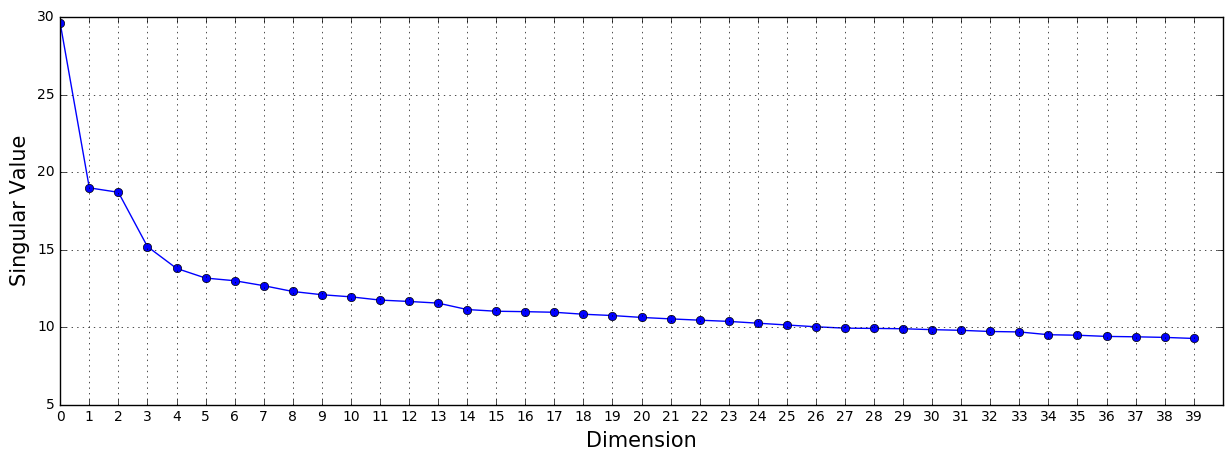

In [28]:
draw_plot(S1, xlabel='Dimension', ylabel='Singular Value')

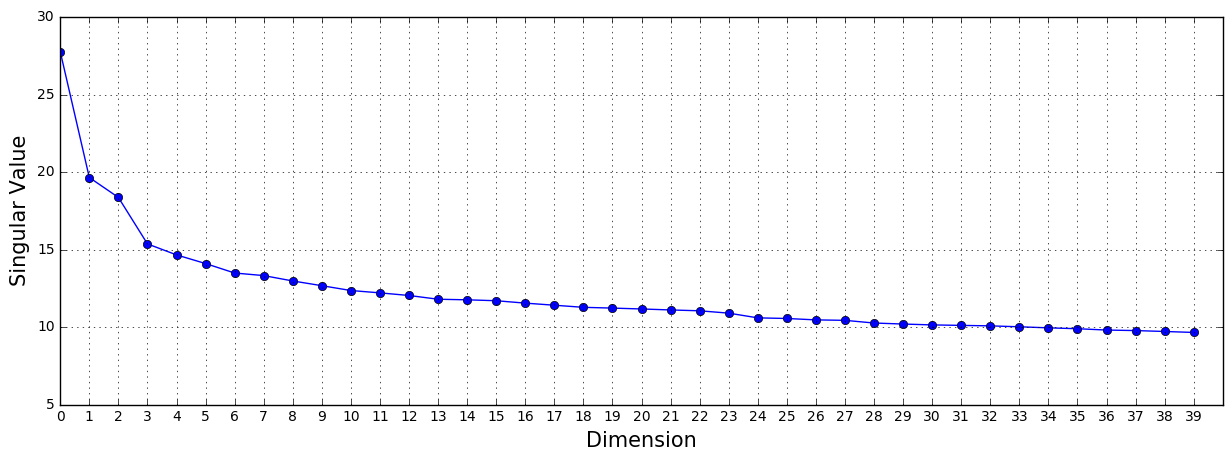

In [29]:
draw_plot(S2, xlabel='Dimension', ylabel='Singular Value')

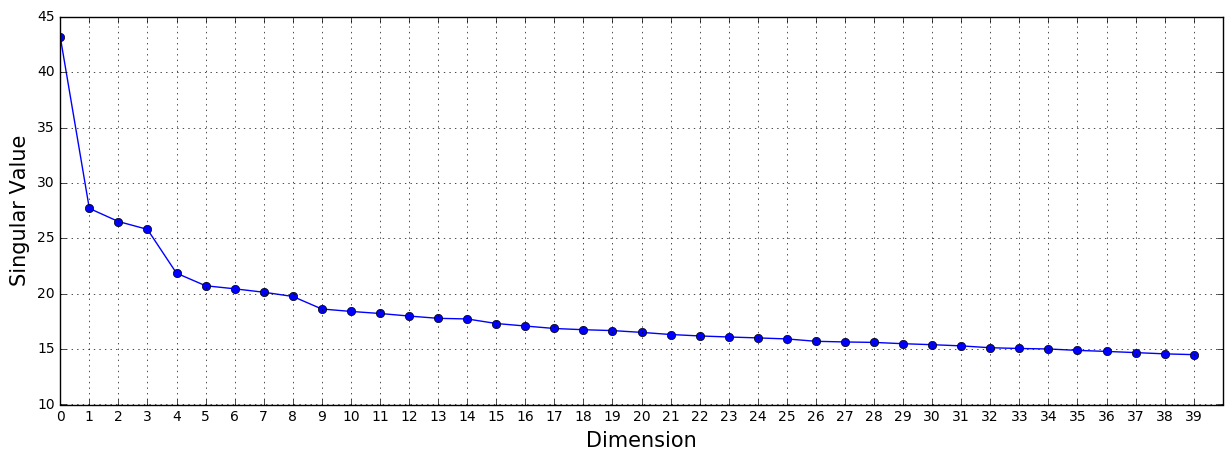

In [30]:
draw_plot(S3, xlabel='Dimension', ylabel='Singular Value')

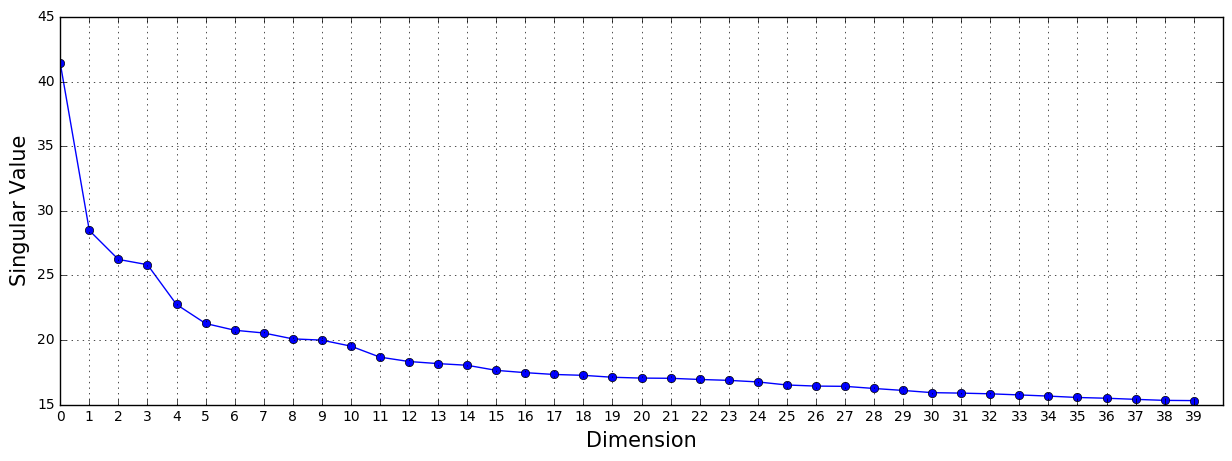

In [31]:
draw_plot(S4, xlabel='Dimension', ylabel='Singular Value')

In [19]:
terms1 = np.array(Vectorize1.get_feature_names())
tops1 = []
for i in range(8):
    top1 = VT1[i].argsort()[::-1]
    topterms1 = [terms1[top1[f]] for f in range(50)]
    print(i, topterms1)
    tops1.append(set(topterms1))

0 ['twitter', 'pic', 'vote', 'enjoy', 'want', 'flag', 'profile', 'unlocked', 'tweet', 'today', 'shit', 'im', '100s', 'ets', 'cityfalcon', 'day', 'stay', 'coming', 'goodbye', 'stories', 'lets', 'dont', 'trust', 'needs', 'dailysquib', 'best', 'days', 'breitbart', 'message', 'poster', 'choice', 'failed', 'rt', 'save', 'taxation', 'wont', 'picture', 'played', 'time', 'june', 'future', 'funding', 'life', 'europewatch', 'late', 'summary', 'true', 'tomorrow', 'cartoon', 'comparing']
1 ['eu', 'referendum', 'uk', 'leave', 'bbc', 'twitter', 'cs', 'britain', 'pic', 'trade', 'leaving', 'membership', 'html', 'safer', 'better', 'law', 'outside', 'deal', 'says', 'stay', 'dailysquib', 'member', 'remain', 'turkey', 'poll', 'debate', 'warns', 'army', 'security', 'join', 'pro', 'exit', 'leaves', 'rules', 'st', 'mean', 'does', 'free', 'remaining', 'funding', 'live', 'report', 'cost', 'votes', 'redundant', 'ahead', 'staying', 'money', 'benefits', 'democratic']
2 ['vote', 'eu', 'unlocked', 'profile', 'flag'

In [20]:
terms2 = np.array(Vectorize2.get_feature_names())
tops2 = []
for i in range(8):
    top2 = VT2[i].argsort()[::-1]
    topterms2 = [terms2[top2[f]] for f in range(50)]
    print(i, topterms2)
    tops2.append(set(topterms2))

0 ['pic', 'twitter', 'vote', 'thi', 'enjoy', 'profil', 'flag', 'unlock', 'want', 'tweet', 'day', 'today', 'shit', 'im', '100', 'cityfalcon', 'et', 'let', 'dont', 'goodby', 'poster', 'trust', 'stori', 'rt', 'dailysquib', 'stay', 'choic', 'futur', 'messag', 'best', 'breitbart', 'come', 'spot', 'taxat', 'tomorrow', 'wont', 'pictur', 'know', 'failur', 'ote', 'need', 'europewatch', 'cartoon', 'thank', 'event', 'question', 'guid', 'imag', 'alien', 'fail']
1 ['vote', 'unlock', 'profil', 'flag', 'leav', 'remain', 'poll', 'regist', 'june', 'peopl', 'referendum', 'pleas', 'whi', 'reason', 'futur', 'britain', 'today', '23rd', 'stay', 'way', 'cast', 'count', 'postal', 'did', 'sure', 'll', 'befor', 'tomorrow', 'result', 'bother', 'te', 'goodby', 'young', 'rt', 'thursday', 'lead', 'decid', 'gov', 'hour', 'becaus', 'retweet', 'elect', 'everyon', 'intent', 'regret', 'chanc', 'anyon', 'import', 'brit', 'forget']
2 ['eu', 'uk', 'referendum', 'leav', 'britain', 'bbc', 'twitter', 'cs', 'remain', 'pic', 't

In [21]:
terms3 = np.array(Vectorize3.get_feature_names())
tops3 = []
for i in range(8):
    top3 = VT3[i].argsort()[::-1]
    topterms3 = [terms3[top3[f]] for f in range(50)]
    print(i, topterms3)
    tops3.append(set(topterms3))

0 ['twitter', 'pic', 'page', 'fb', 'brexit', 'time', 'vote', 'blog', 'facebook', 'britain', 'june', 'rt', '23rd', 'tweet', 'battle', 'flag', 'goodbye', 'soldier', 'today', 'im', 'needs', 'leave', 'billion', 'shit', 'let', 'betrayal', 'enjoy', 'law', 'unlocked', 'profile', 'cat', 'want', 'children', 'winston', 'control', 'dont', 'nation', 'old', 'remember', 'ukleave_eu', 'think', 'churchill', 'lets', 'bag', 'lied', 'juncker', 'campaigning', 'waste', 'retweet', 'govern']
1 ['eu', 'vote', 'leave', 'referendum', 'uk', 'britain', 'remain', 'html', 'stay', 'pic', 'dailysquib', 'twitter', 'trade', 'want', 'reasons', 'cs', 'bbc', 'turkey', 'voting', 'youtube', 'support', 'army', 'funded', 'europe', 'add', 'help', 'unlocked', 'outside', 'poll', 'profile', 'million', 'leaving', 'claims', 'leaflet', 'june', 'flag', 'lse', 'taxpayer', 'uncovered', 'gov', 'join', 'reasonstovoteleave', 'nhs', 'pro', 'law', 'risks', 'workers', 'membership', 'staying', 'safer']
2 ['vote', 'leave', 'remain', 'brexit', 

In [22]:
terms4 = np.array(Vectorize4.get_feature_names())
tops4 = []
for i in range(8):
    top4 = VT4[i].argsort()[::-1]
    topterms4 = [terms4[top4[f]] for f in range(50)]
    print(i, topterms4)
    tops4.append(set(topterms4))

0 ['pic', 'twitter', 'page', 'fb', 'brexit', 'time', 'vote', 'blog', 'thi', 'facebook', 'britain', 'june', '23rd', 'rt', 'let', 'tweet', 'battl', 'flag', 'goodby', 'leav', 'im', 'today', 'soldier', 'day', 'shit', 'profil', 'unlock', 'enjoy', 'cat', 'juncker', 'children', 'dont', 'billion', 'rememb', 'winston', 'churchil', 'ukleave_eu', 'old', 'control', 'bag', 'commun', 'betray', 'fish', 'imagin', 'interf', 'mug', 'readi', 'switzerland', 'retweet', 'era']
1 ['vote', 'leav', 'eu', 'whi', 'remain', 'referendum', 'britain', 'june', 'reason', 'stay', 'unlock', 'uk', 'profil', '23rd', 'flag', 'poll', 'want', 'html', 'join', 'pleas', 'save', 'dailysquib', 'nh', 'democraci', 'support', 'healthcar', 'reasonstovoteleav', 'europ', 'add', 'regist', 'worker', 'help', 'futur', 'postal', 'll', 'risk', 'count', 'union', 'pic', 'trade', 'goodby', 'cs', 'undecid', 'thursday', 'urg', 'te', 'turkey', 'time', 'say', 'demis']
2 ['eu', 'brexit', 'uk', 'britain', 'page', 'fb', 'leav', 'referendum', 'html', '

## Top Five Tags for Remain

0. Economy/Trade
1. Jobs/Market/Risk
2. Law/Govern
3. Security
4. Nation/Leader

## Top Five Tags for Leave

1. Freedom/Sovereignty/Great
2. Tax
3. Economy/Trade
4. Migrants
5. Lie/Brussels

## Kmeans

In [23]:
Xk1 = U1 @ np.diag(S1)

In [24]:
error = np.zeros(31)
for k in range(1,31):
    vectorsk1 = Xk1[:,:k]
    kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk1)
    error[k] = kmeans.inertia_

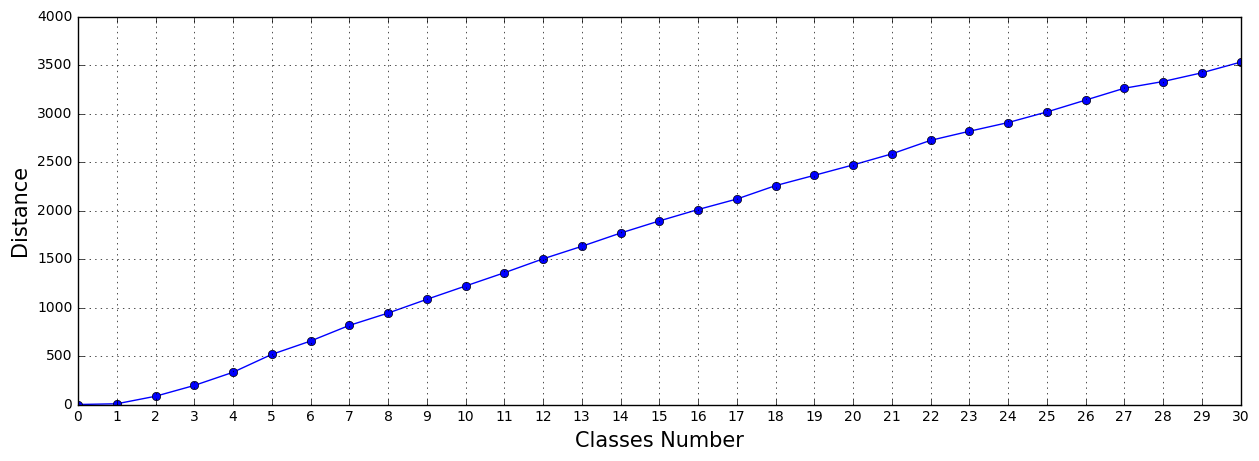

In [32]:
draw_plot(error, xlabel='Dimension Number', ylabel='Distance')

In [33]:
error = np.zeros(31)
for k in range(1,31):
    vectorsk1 = Xk1[:,:2]
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk1)
    error[k] = kmeans.inertia_

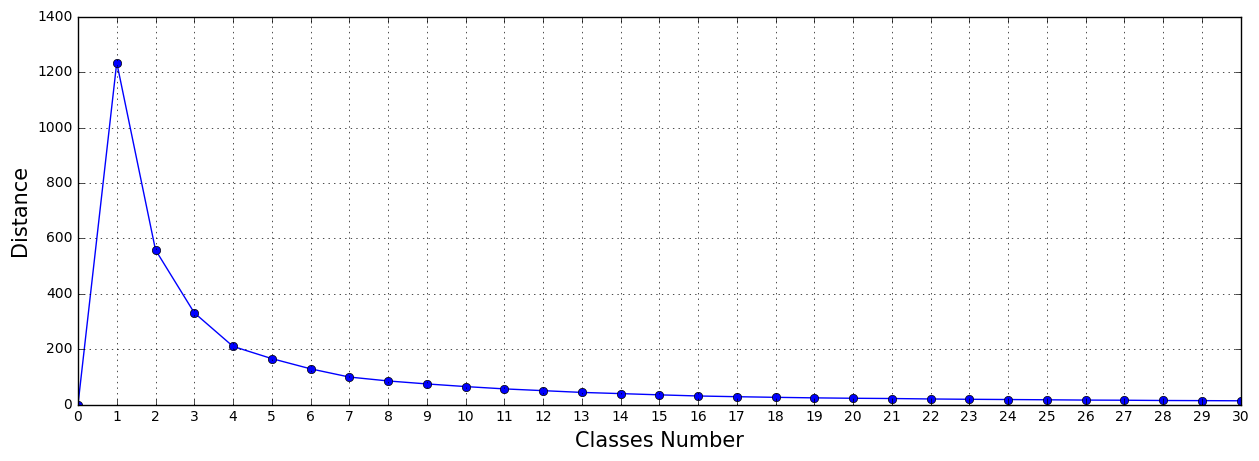

In [35]:
draw_plot(error, xlabel='Classes Number', ylabel='Distance')

In [36]:
Xk3 = U3 @ np.diag(S3)

In [37]:
error3 = np.zeros(31)
for k in range(1,31):
    vectorsk3 = Xk3[:,:2]
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(vectorsk3)
    error3[k] = kmeans.inertia_

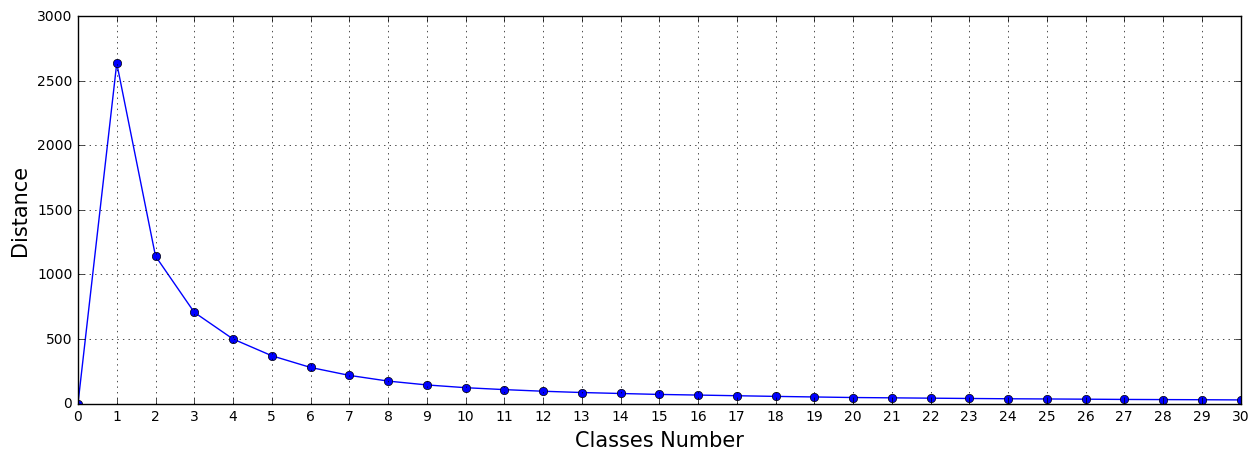

In [39]:
draw_plot(error3, xlabel='Classes Number', ylabel='Distance')

In [40]:
Xk1 = U1 @ np.diag(S1)

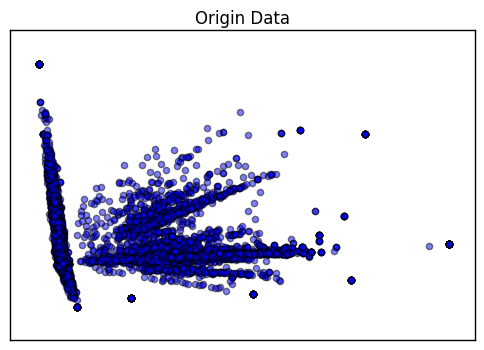

In [175]:
draw_scatter(Xk1[:,:2],"Origin Data")

In [266]:
Xk1 = U1 @ np.diag(S1)
N = 5
vectorsk_remain = Xk1[:,:2]
kmeans_remain = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_remain.fit_predict(vectorsk_remain)
labelsk_remain = kmeans_remain.labels_

Xk2 = U2 @ np.diag(S2)
vectorsk_remain_stem = Xk2[:,:2]
kmeans_remain_stem = KMeans(n_clusters=N, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_remain_stem.fit_predict(vectorsk_remain_stem)
labelsk_remain_stem = kmeans_remain_stem.labels_

df_remain['kmean_remain'] = kmeans_remain.labels_
df_remain['kmean_remain_stem'] = kmeans_remain_stem.labels_

ktag_remain=[]
for i in range(N):
    df_remain.index = df_remain['kmean_remain']
    cdis = euclidean_distances(vectorsk_remain[df_remain.ix[i]['Unnamed: 0'].values,:2], [kmeans_remain.cluster_centers_[i]]).T.argsort()
    top1 = cdis[0][:10]
    
    df_remain.index = df_remain['kmean_remain_stem']
    cdis_stem = euclidean_distances(vectorsk_remain_stem[df_remain.ix[i]['Unnamed: 0'].values,:2], [kmeans_remain_stem.cluster_centers_[i]]).T.argsort()
    top1_stem = cdis_stem[0][:10]
    
    indeces = list(set(top1) | set(top1_stem))
    ktag_remain.append(df_remain.iloc[indeces]['text'].values)

In [275]:
ktag_remain[1]

array(['EU Commission cuts euro zone growth forecast not good news for the UK',
       'Potential policy and environmental consequences for the UK of leaving the EU',
       "Energy secretary warns of 500m 'electric shock' after theguardian",
       "Since folk endlessly repeat 'it's that keeps us safe' I hope they attend to this",
       "Nevermind parliamentary sovereignty we MUST decide Britain's future based on what Putin may or may not want We are",
       'Head of Leave campaign admits would cost families 4K pa and higher prices their economist says wages would fall',
       'calls tax controversy tripe Same ignorance on economics leads him to think a good idea',
       "Watch here why a vote for Remain isn't a vote for certainty or status quo",
       'All university ministers over the past years say harms UK universities facebook',
       'yeah right via',
       'I think it more likely they just made it up If wants vote',
       'And if the does not understand equal rights amo

In [181]:
# def find_topics(texts):
texts = ktag_remain
classes = len(texts)
sentences = len(texts[0])

stemmer = PorterStemmer()
for i in range(classes):
    stemmed_data = [" ".join(stemmer.stem(word)  for sent in sent_tokenize(message) for word in word_tokenize(sent)) for message in texts[i]]
    texts[i] = stemmed_data


    

In [188]:
Vectorize = TfidfVectorizer(min_df = 0.0005, max_df = 0.6, stop_words = 'english')
dtm = Vectorize.fit_transform(texts[0])

In [217]:
Vectorize.get_feature_names()[16]

'campaign'

In [205]:
dtm.sum(axis=0).argsort()

matrix([[ 15,  84,  31,  32,  24,  44,  68,  98, 126,  93,  69,   4,  79,
         116,   5, 110,  72, 102,  75,  87,  63,  29,  13,  73,  37, 133,
          97,  74,  86,  52,  85,  35, 115,   7,   6, 132,  19,  34,  10,
          50,  43, 101,  22,  56,  65,  49, 134,   8,  14, 103, 128,  42,
          36,  33,  28,  83,  17,  61,  91,  18,  71,  88,  95,  48,  76,
         111,  80,  81,  96, 117, 122, 109,   0,  66,   3,  70,  27,  30,
          46,  47,  55,  25,  64, 108, 112, 123, 124,  89,  94,  77,   9,
          58, 119,  12, 129, 104, 106, 100,  11,  21, 113,   2, 118, 121,
           1, 130, 127,  23,  82,  99,  92,  53,  41,  26,  51,  60,  59,
          38,  39,  57,  67, 114,  90,  62, 105, 120,  40,  45, 131, 125,
          78,  16,  20, 107,  54]])

In [125]:
ktexts_remain = ''
for i in ktag_remain:
    temp = ' '.join(i)
    ktexts_remain += temp
    

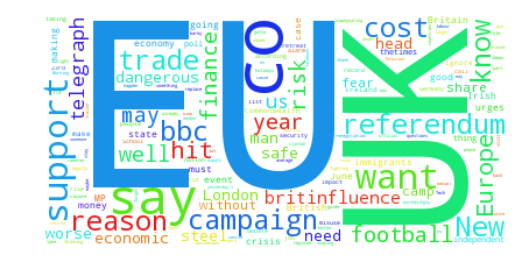

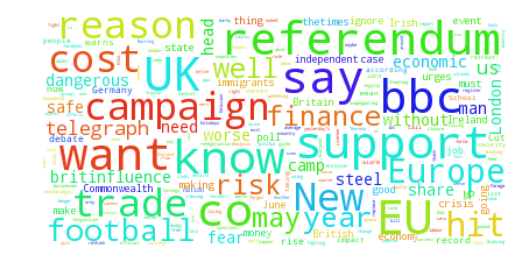

In [126]:
word_cloud(ktexts_remain)

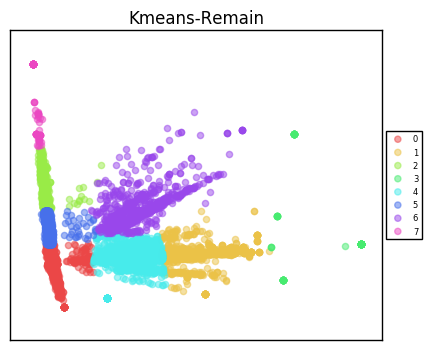

In [264]:
draw_scatter(X=Xk1, num=N, label=kmeans_remain.labels_, title="Kmeans-Remain")

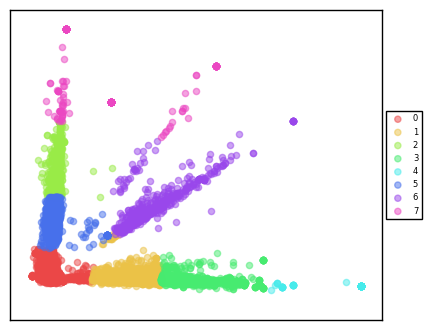

In [58]:
draw_scatter(X=Xk2, num=8, label=kmeans_remain_stem.labels_)

In [278]:
Xk3 = U3 @ np.diag(S3)
lN = 5
vectorsk_leave = Xk3[:,:2]
kmeans_leave = KMeans(n_clusters=lN, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_leave.fit_predict(vectorsk_leave)
labelsk_leave = kmeans_leave.labels_

Xk4 = U4 @ np.diag(S4)
vectorsk_leave_stem = Xk4[:,:2]
kmeans_leave_stem = KMeans(n_clusters=lN, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans_leave_stem.fit_predict(vectorsk_leave_stem)
labelsk_leave_stem = kmeans_leave_stem.labels_

df_leave['kmean_leave'] = kmeans_leave.labels_
df_leave['kmean_leave_stem'] = kmeans_leave_stem.labels_

ktag_leave=[]
for i in range(lN):
    df_leave.index = df_leave['kmean_leave']
    cdis = euclidean_distances(vectorsk_leave[df_leave.ix[i]['Unnamed: 0'].values,:2], [kmeans_leave.cluster_centers_[i]]).T.argsort()
    top1 = cdis[0][:10]
    
    df_leave.index = df_leave['kmean_leave_stem']
    cdis_stem = euclidean_distances(vectorsk_leave_stem[df_leave.ix[i]['Unnamed: 0'].values,:2], [kmeans_leave_stem.cluster_centers_[i]]).T.argsort()
    top1_stem = cdis_stem[0][:10]
    
    indeces = list(set(top1) | set(top1_stem))
    ktag_leave.append(df_leave.iloc[indeces]['text'].values)

In [283]:
ktag_leave[4]

array(['Warning about Turkey pic twitter',
       'Treasury report is out Quick press the alarm pic twitter',
       'A bit obvious really',
       "The only one I'd trust in this line up is the one in the scream mask",
       'the globalist threatening Britons He can be so proud of his own failure pic twitter',
       "here's why I choose to for Britannia pic twitter",
       'Back of the queue What a disgraceful remark for a head of state to make to a close ally',
       "list of criminals This guy took thousands in taxpayers money then didn't do his job Fraud pic twitter",
       "I'll raise a glass to that", "You've just made the case for",
       'must resign with vote A new Britain needs new leadership',
       'IN UK OUT pic twitter', 'SAVE OUR STEEL e our steel',
       'The Anti faction talks of freedom and democracy The Anti Democracy faction talks only of money',
       'we gave YOUR EU a try and to be honest it was shit Can we have our 500b back please',
       "POTUS IS CL

In [132]:
ktexts_leave=''
for i in ktag_leave:
    temp = ' '.join(i)
    ktexts_leave += temp

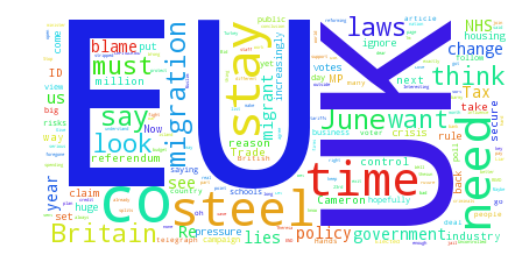

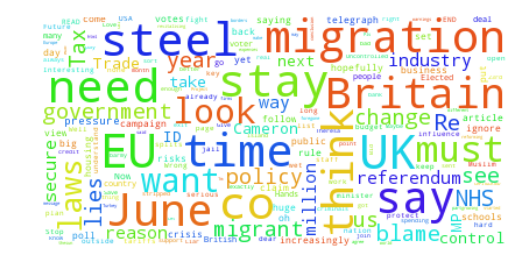

In [133]:
word_cloud(ktexts_leave)

In [ ]:
leave_label=[]

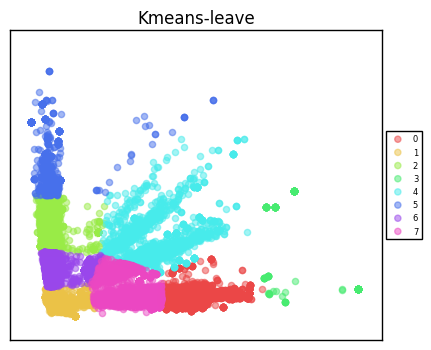

In [260]:
draw_scatter(X=Xk3, num=lN, label=kmeans_leave.labels_,title='Kmeans-leave')

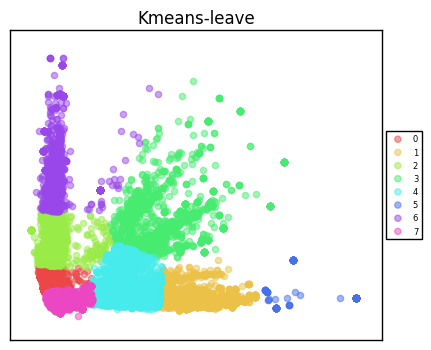

In [263]:
draw_scatter(X=Xk4, num=lN, label=kmeans_leave_stem.labels_,title='Kmeans-leave')

## GMM

In [284]:
def GMMchoseK(Xk):
    # to estimate GMM model
    N = 10
    error = np.zeros(N)
    for k in range(1, N):
        feature = Xk[:,:2]
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(feature)
        gmm.predict(feature)
        error[k] = gmm.score(feature)
    # number of classes and likelyhood
    draw_plot(error, xlabel='Classes Number', ylabel='Likelyhood') 

In [288]:
def GMM(X,df):
    feature = X[:,:2]
    # Do GMM classification and plot
    gnum = 4
    gmm = mixture.GaussianMixture(n_components=gnum, covariance_type='full')
    gmm.fit(feature)
    gclusters = gmm.predict(feature)
    draw_scatter(feature, label=gclusters, num=gnum,title='GMM')

    # get the probability of each point in each class and get the largest probability
    pro = gmm.predict_proba(feature)
    pros = [i.max() for i in pro]
    # build a data frame contain the cluster this point belonging to, and its probability, and its index in the origin table
    df_gmm = pd.DataFrame(data=gclusters, columns = ['cluster'])
    df_gmm['Pro'] = pros
    df_gmm['index'] = np.array(range(len(feature)))
    # make cluster as the index of data frame
    df_gmm.index = df_gmm['cluster']
    # print the size of each cluster
    print('Categories of {} cluster by GMM'.format(gnum))
    for k in range(gnum):
        print('Cluster {} size: {}'.format(k + 1, len(df_gmm.ix[k])))

    # for each cluster sort the its point in the probability, take the point has most prosibble belonging this 
    # cluster, its label as the label for this cluster
    gtag = []
    for k in range(gnum):
        first10 = df_gmm.ix[k].sort_values(['Pro'], ascending = False)['index'][0:10].values
        gtag.append(df.iloc[first10]['text'].values)
    return gtag

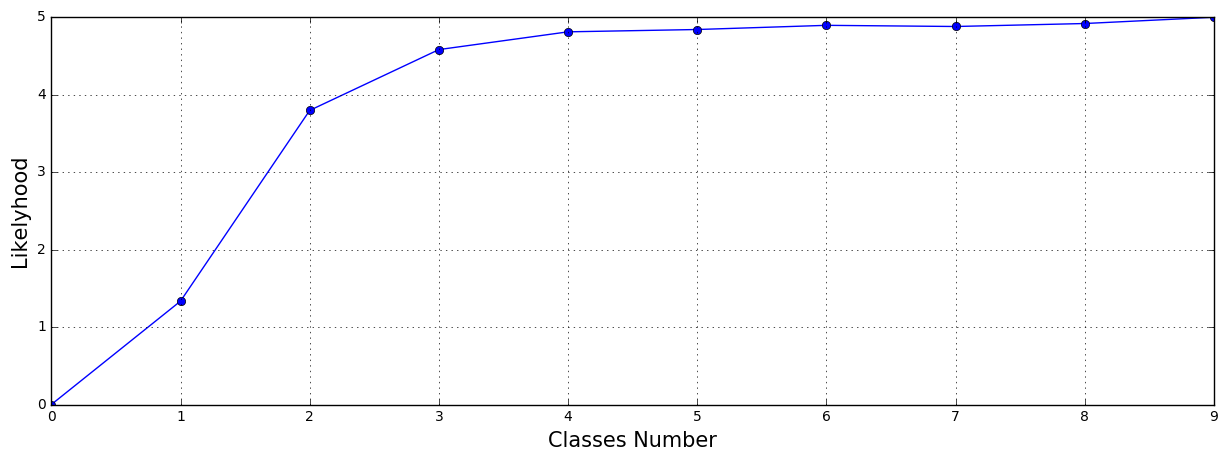

In [286]:
Xk1 = U1 @ np.diag(S1)
GMMchoseK(Xk1)

Categories of 4 cluster by GMM
Cluster 1 size: 11810
Cluster 2 size: 4728
Cluster 3 size: 17196
Cluster 4 size: 2671


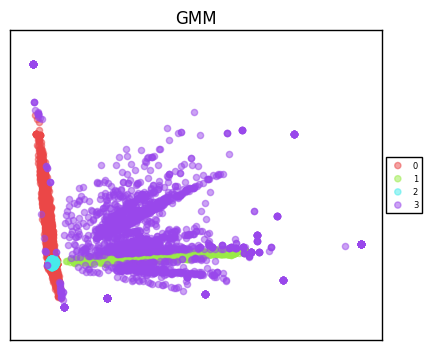

In [289]:
gtag1 = GMM(Xk1, df_remain)

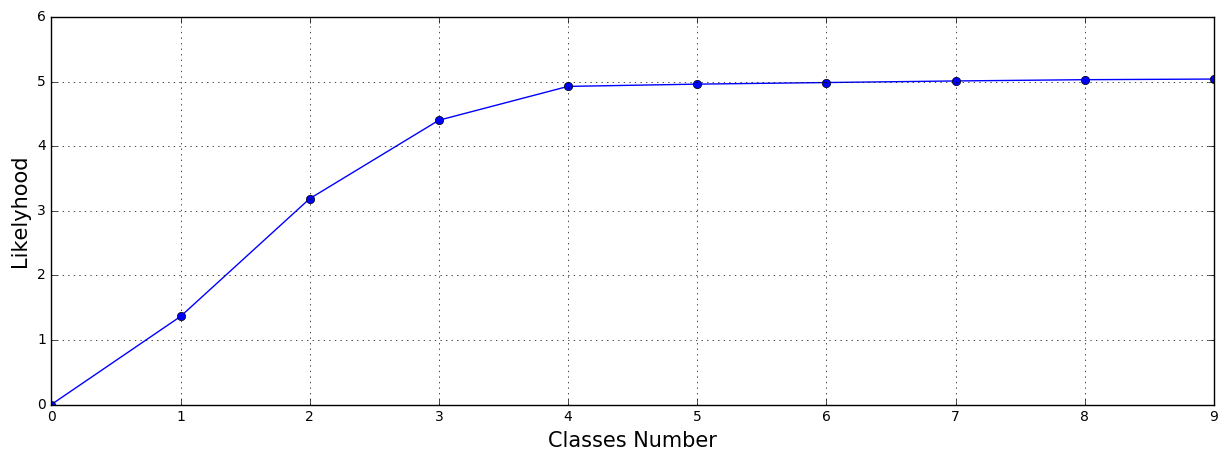

In [290]:
Xk2 = U2 @ np.diag(S2)
GMMchoseK(Xk2)

Categories of 4 cluster by GMM
Cluster 1 size: 23886
Cluster 2 size: 6033
Cluster 3 size: 5030
Cluster 4 size: 1456


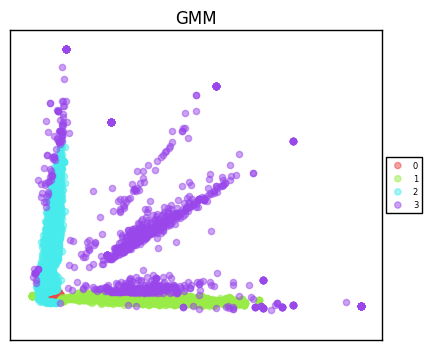

In [291]:
gtag2=GMM(Xk2,df_remain)

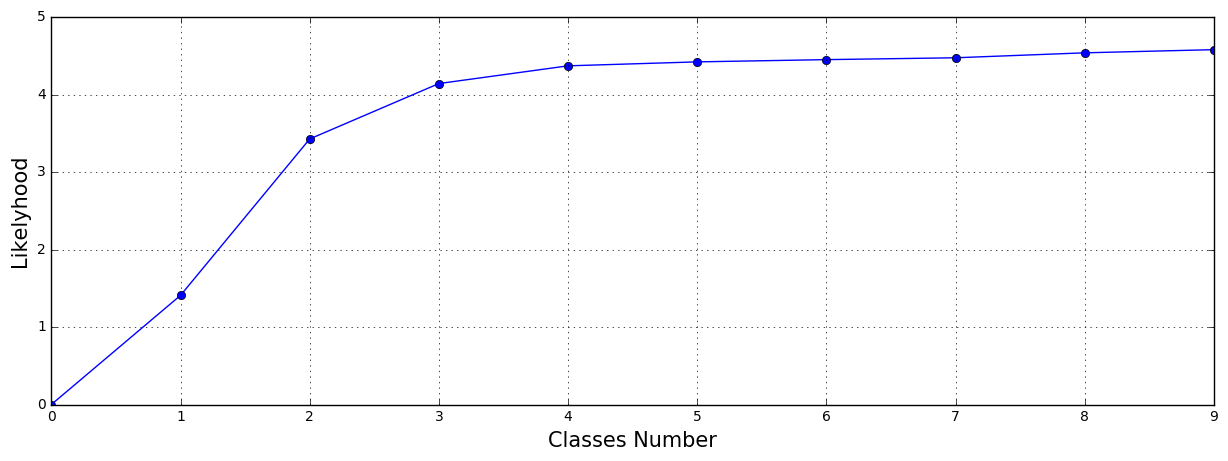

In [292]:
Xk3 = U3 @ np.diag(S3)
GMMchoseK(Xk3)

Categories of 4 cluster by GMM
Cluster 1 size: 38225
Cluster 2 size: 4969
Cluster 3 size: 16466
Cluster 4 size: 23954


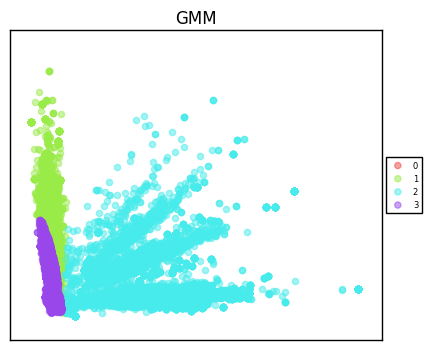

In [293]:
gtag3=GMM(Xk3,df_leave)

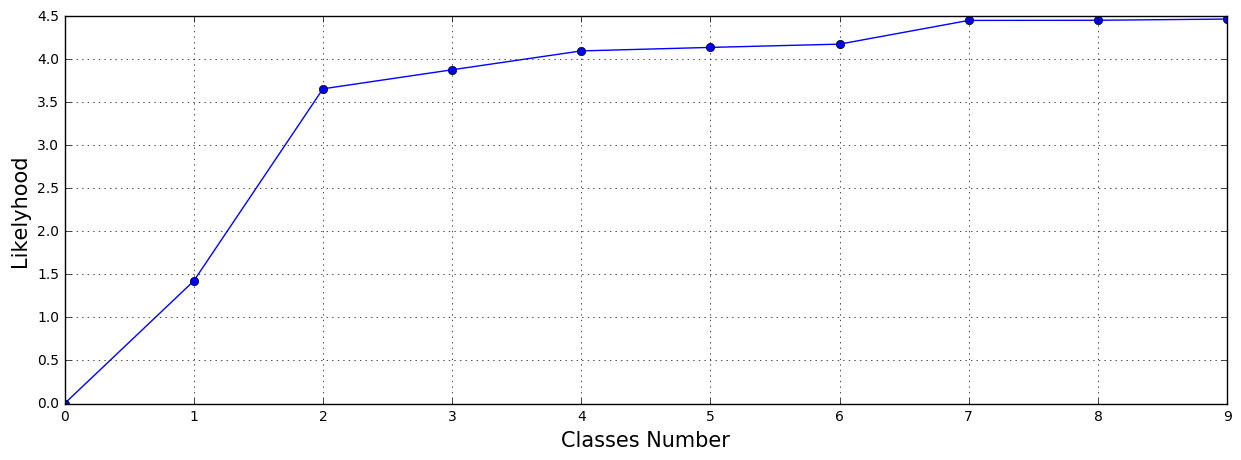

In [294]:
Xk4 = U4 @ np.diag(S4)
GMMchoseK(Xk4)

Categories of 4 cluster by GMM
Cluster 1 size: 53452
Cluster 2 size: 3559
Cluster 3 size: 12252
Cluster 4 size: 14351


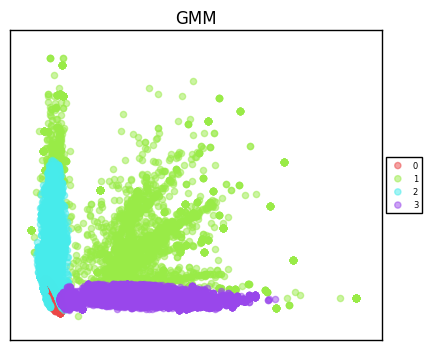

In [295]:
gtag4=GMM(Xk4,df_leave)

In [297]:
gtag_remain = [np.concatenate([gtag1[i], gtag2[i]]) for i in range(len(gtag1))]
gtag_leave = [np.concatenate([gtag3[i], gtag4[i]]) for i in range(len(gtag3))]

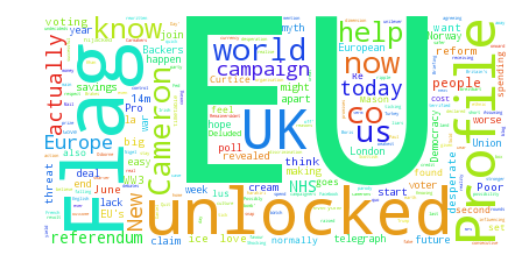

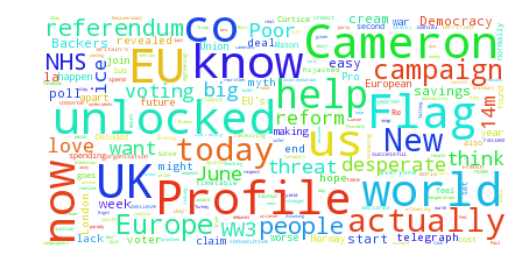

In [146]:
gtexts_remain = ''
for i in gtag_remain:
    temp = ' '.join(i)
    gtexts_remain += temp
word_cloud(gtexts_remain)

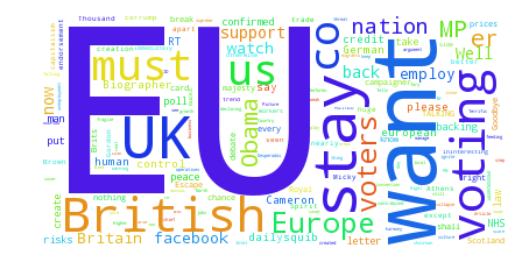

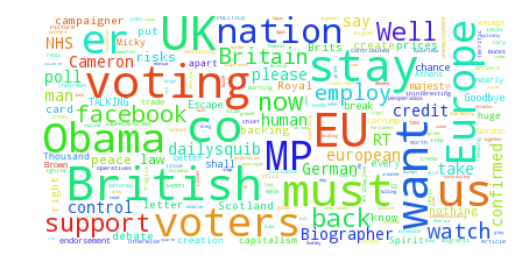

In [149]:
gtexts_leave = ''
for i in gtag_leave:
    temp = ' '.join(i)
    gtexts_leave += temp
word_cloud(gtexts_leave)

In [309]:
gtag_leave[3]

array([ 'IF BEING IN THE EU IS SO GOOD Why do we have a non existent police force Why do we have crap hospitals',
       'Cameron wants to surrender the UK to EU dictatorship after we fought wars in the name of freedom Idiot',
       'WARNING Migrant crisis to get worse and EU to cost Britons BILLIONS if we stay',
       "Remain say we have a large influence in the EU yet we can't even abolish a tampon tax Wake up people",
       'Voting remain Consider this President of EU has just dealt a serious blow to Cameron NO reform independent co',
       'Eu not Europe helps to keep wages down so bosses like it but not great for emplyees',
       'The vast majority of Americans I talk to cannot understand why UK is a member of the EU especially Texans',
       'The vast majority of Americans I talk to cannot understand why UK is a member of the EU especially Texans',
       'EU countries could be fined millions for refusing to accept refugees independent co euros per refugee',
       'was com

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot and label each cluster. 

Note that to label each cluster, you will need to think about how to extract labels from the LSA results.
**(25 pts)**

## Hierarchical Clustering

In [30]:
feature = set_feature(df, 0.7)

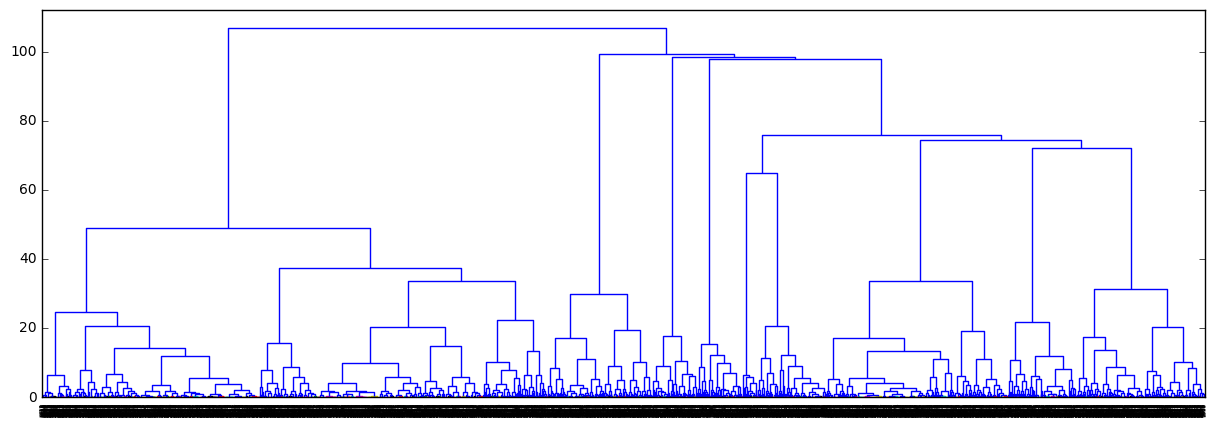

In [31]:
plt.figure(figsize=(15,5))
Z = hr.linkage(feature, method='ward', metric='euclidean')
T = hr.dendrogram(Z,color_threshold=0.4, leaf_font_size=4)

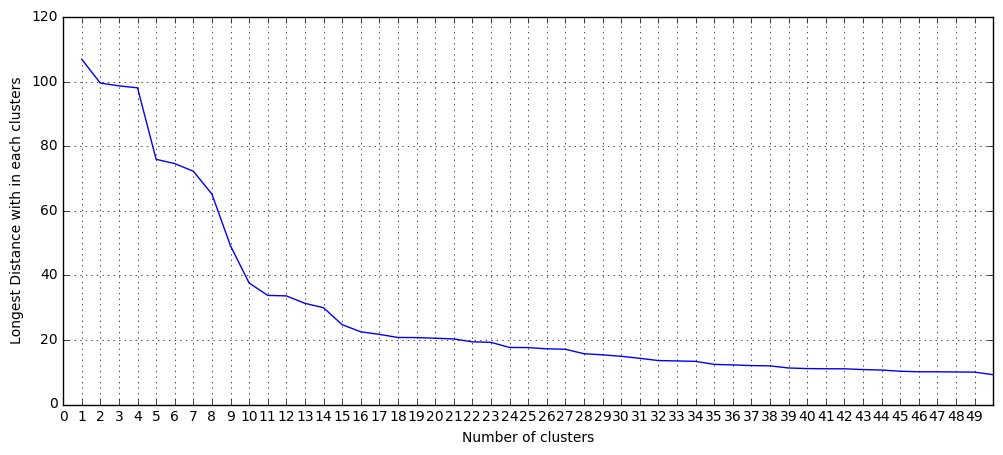

In [32]:
last = Z[-50:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(12,5))
_ = plt.plot(idxs, last_rev)
plt.xlabel('Number of clusters')
plt.xticks(range(50))
plt.grid(True)
dummy = plt.ylabel('Longest Distance with in each clusters')

In [33]:
hnum = 15
hcluster = hr.fcluster(Z, hnum ,'maxclust') - 1

In [34]:
df['hr'] = hcluster
df.index = df['hr']
# print the size of each cluster
for i in range(hnum):
    print("Cluster {} size : {}".format(i, len(df.ix[i])))

Cluster 0 size : 920
Cluster 1 size : 244
Cluster 2 size : 698
Cluster 3 size : 272
Cluster 4 size : 238
Cluster 5 size : 205
Cluster 6 size : 192
Cluster 7 size : 189
Cluster 8 size : 59
Cluster 9 size : 297
Cluster 10 size : 536
Cluster 11 size : 230
Cluster 12 size : 286
Cluster 13 size : 289
Cluster 14 size : 255


In [35]:
# print the label of each cluster
htag = []
Vectorizer = TfidfVectorizer()
for i in range(hnum):
    hcategories = Vectorizer.fit_transform(df.ix[i]['categories'].values).toarray()
    hTopIndex = hcategories.sum(axis = 0).argsort()[-2:]
    hTop1Ca = np.array(Vectorizer.get_feature_names())[hTopIndex]
    if len(hTop1Ca) == 2:
        temp = hTop1Ca[0]+'/'+hTop1Ca[1]
    else: temp = hTop1Ca[0]
    htag.append(temp)
    print('Cluster {} :'.format(i + 1)+ temp)

Cluster 1 :chinese/thai
Cluster 2 :thai/chinese
Cluster 3 :chinese/thai
Cluster 4 :chinese
Cluster 5 :italian/pizza
Cluster 6 :italian/pizza
Cluster 7 :japanese/sushi
Cluster 8 :bbq/korean
Cluster 9 :fast_food/vietnames
Cluster 10 :fast_food
Cluster 11 :bar
Cluster 12 :bar
Cluster 13 :breakfast
Cluster 14 :mexian
Cluster 15 :mexian


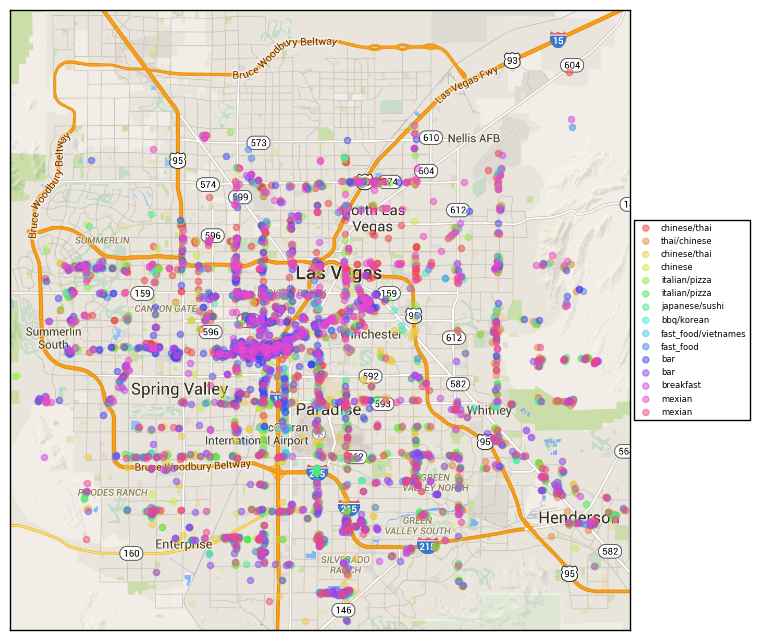

In [36]:
draw_map(hnum, 'hr', df, hcluster, htag)

Compare your clusters with the results you obtained in Part 1. Use cluster comparison metrics, and also comment on which clustering appears (from your inspection of the clusters) to be more informative, and why. **(15 pts)**